# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.


## Data Preparation

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe. While importing all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

mam_data = pd.read_csv("mammographic_masses.data.txt")

In [2]:
mam_data.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

In [3]:
#We set the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN,
#and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity)
mam_data = pd.read_csv("mammographic_masses.data.txt",
                      names = ['BI-RADS','Age', 'Shape', 'Margin', 'Density', 'Severity'],
                      na_values= ['?'])

In [4]:
mam_data.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Evaluate whether the data needs cleaning using the describe() method.

In [5]:
mam_data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [6]:
mam_data.loc[(mam_data['Age'].isnull()) |
              (mam_data['Shape'].isnull()) |
              (mam_data['Margin'].isnull()) |
              (mam_data['Density'].isnull())]

,BI-RADS,Age,Shape,Margin,Density,Severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
9,5.0,60.0,NaN,5.0,1.0,1
12,4.0,64.0,1.0,NaN,3.0,0
19,4.0,40.0,1.0,NaN,NaN,0
20,NaN,66.0,NaN,NaN,1.0,1
22,4.0,43.0,1.0,NaN,NaN,0


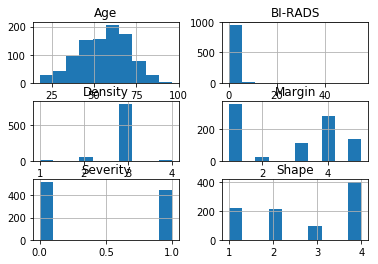

In [7]:
mam_data.hist()
plt.rcParams["figure.figsize"] = 20,20

As the missing data seems randomly distributed, we drop the rows with missing data.

In [8]:
mam_data.dropna(inplace=True)

mam_data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Next we will need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn.

## Data Insights and Visualizations:

In [9]:

mam_data.groupby("Severity").count()

,BI-RADS,Age,Shape,Margin,Density
Severity,,,,,
0,427,427,427,427,427
1,403,403,403,403,403


In [10]:
#Importing libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

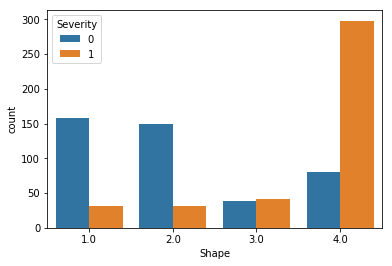

In [11]:
sns.countplot("Shape", data = mam_data, hue= 'Severity')
plt.rcParams["figure.figsize"] = 15, 8

As we can see from the above plot, the Severity increases with increasing shapes. Whereas it decreases as the shape size decrements.

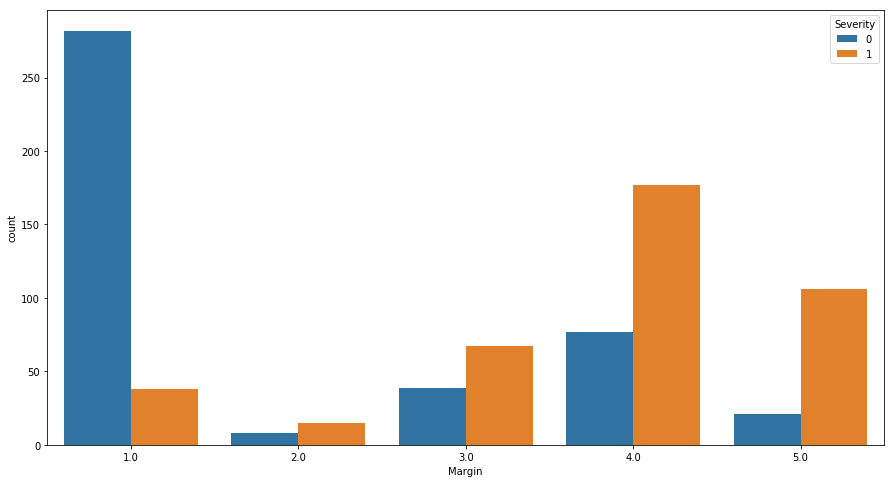

In [12]:
sns.countplot("Margin", data = mam_data, hue= 'Severity')
plt.rcParams["figure.figsize"] = 15,8

Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
The Severity seems to be pretty low with the lowest marginal Mass(circumscribed mass), while it appears to be the most severe in the case with the highest marginal masses(ill-defined, spiculated) as seen from above. 

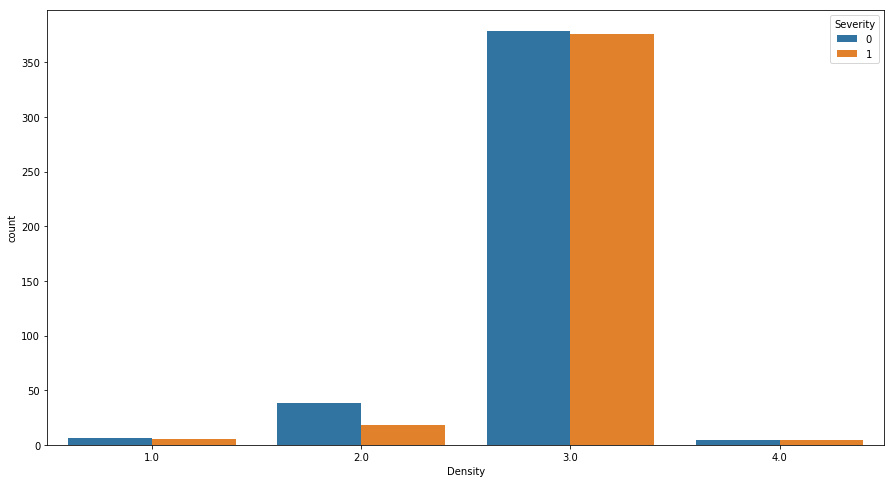

In [13]:
sns.countplot("Density", data = mam_data, hue= 'Severity')
plt.rcParams["figure.figsize"] = 10,8

As it appears, the low density mass(3.0) contributes to the most of Severity in comparison to other densities.

## Machine Learning

Next we'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn.

In [14]:
#Covert dataframes to numpy array for using sci learn
#Setting aside features and labels
#Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) 
#and another array that contains the classes (severity).

X = mam_data[['Age', 'Shape', 'Margin', 'Density']].values

Y = mam_data['Severity'].values

X

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

In [15]:
mam_data["Age"].describe()

count    830.000000
mean      55.781928
std       14.671782
min       18.000000
25%       46.000000
50%       57.000000
75%       66.000000
max       96.000000
Name: Age, dtype: float64

Some of our models require the input data to be normalized, so we'll use the preprocessing.StandardScaler() function in scikit learn.

In [16]:
#Normalize the data
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X_scaled = scaler.fit_transform(X)

In [17]:
X_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

## Decision Tree

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [18]:
#Split the data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled,Y)

Now create a DecisionTreeClassifier and fit it to your training data.

In [19]:

from sklearn.tree import DecisionTreeClassifier

Dec_mod = DecisionTreeClassifier()

#Train the model on the training set
Dec_mod.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Model Evaluation

In [41]:
predicted = Dec_mod.predict(X_test)

expected = Y_test

In [42]:
#Predicting the score
from sklearn import metrics

metrics.accuracy_score(predicted,expected)

0.7548076923076923

In [43]:
#Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[79 27]
 [24 78]]


In [44]:
#Precision-Recall score
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       106
           1       0.74      0.76      0.75       102

   micro avg       0.75      0.75      0.75       208
   macro avg       0.75      0.75      0.75       208
weighted avg       0.76      0.75      0.75       208



Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [45]:
from sklearn.model_selection import cross_val_score

Dec_mod = DecisionTreeClassifier()

scores = cross_val_score(Dec_mod, X_scaled, Y, cv= 10)
scores.mean()

0.740913129871402

In [46]:
#Calculating null accuracy for a binary class classification model
#Simpler way
max(Y_test.mean(), 1 - Y_test.mean())

0.5096153846153846

In [47]:
#Classification error
#Misclassification rate
1 - metrics.accuracy_score(Y_test, predicted)

0.2451923076923077

## Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

RF_mod = RandomForestClassifier(n_estimators=10)

scores = cross_val_score(RF_mod, X_scaled, Y, cv = 10)
scores.mean()

0.7481270027846578

## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [50]:
from sklearn.svm import SVC

SVC_mod = SVC(kernel= 'linear', C= 1.0)

scores = cross_val_score(SVC_mod, X_scaled, Y, cv=10)

scores.mean()

0.7964988875362076

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [52]:
from sklearn.neighbors import KNeighborsClassifier

KNN_mod = KNeighborsClassifier(n_neighbors=21)
scores = cross_val_score(KNN_mod, X_scaled, Y, cv=10)
scores.mean()

0.7853927906748946

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [54]:
for n in range(1, 50):
    KNN_mod = KNeighborsClassifier(n_neighbors=n)
    cv_scores = cross_val_score(KNN_mod, X_scaled, Y, cv=10)
    print (n, cv_scores.mean())

1 0.7239123742356184
2 0.6889838098036746
3 0.7541080699103032
4 0.7300813008130081
5 0.7735464506108056
6 0.7626163189342738
7 0.7940595133145824
8 0.7747082406280172
9 0.7880200243482641
10 0.7854795488574507
11 0.7915333809104012
12 0.7794257168045002
13 0.7819084701174035
14 0.7915039950743742
15 0.7878748443250353
16 0.7794411093852764
17 0.7818073688482151
18 0.775681121699341
19 0.7805147418944068
20 0.7828666582707136
21 0.7853927906748946
22 0.7817342540895289
23 0.7805588206484475
24 0.780587506821712
25 0.7878171221471251
26 0.7866269957880302
27 0.7854365195975539
28 0.7902271105327232
29 0.7865979597833844
30 0.7878314652337574
31 0.7914172368918182
32 0.7878314652337574
33 0.7865976099520032
34 0.7866119530386354
35 0.7866262961252677
36 0.7854358199347914
37 0.7866843681345592
38 0.7866553321299133
39 0.7878891874116676
40 0.7854791990260694
41 0.7854645061080558
42 0.7818500482767305
43 0.7830692106404713
44 0.783054867553839
45 0.783054867553839
46 0.7854648559394373
4

# Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

log_mod = LogisticRegression()
scores = cross_val_score(log_mod, X_scaled, Y,cv = 10)
scores.mean()

0.8073583532737221

In [58]:
#Calculating null accuracy for a binary class classification model
#Simpler way
max(Y_test.mean(), 1 - Y_test.mean())

0.5096153846153846

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up?

In [61]:
from sklearn.naive_bayes import GaussianNB

NB_mod = GaussianNB()
scores = cross_val_score(NB_mod, X_scaled, Y, cv=10)

scores.mean()

0.7867865188978912

In [62]:
from sklearn.naive_bayes import MultinomialNB

scaler = preprocessing.MinMaxScaler()
all_features_minmax = scaler.fit_transform(X)

MNB_mod = MultinomialNB()
cv_scores = cross_val_score(MNB_mod, all_features_minmax, Y, cv=10)

cv_scores.mean()

0.7844055665169388

## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [63]:
SVC_mod = SVC(kernel= 'rbf', C= 1.0)

scores = cross_val_score(SVC_mod, X_scaled, Y, cv=15)

scores.mean()

0.8034880551547219

In [64]:
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       106
           1       0.74      0.76      0.75       102

   micro avg       0.75      0.75      0.75       208
   macro avg       0.75      0.75      0.75       208
weighted avg       0.76      0.75      0.75       208



In [65]:
SVC_mod = SVC(kernel= 'sigmoid', C= 1.0)

scores = cross_val_score(SVC_mod, X_scaled, Y, cv=15)

scores.mean()

0.7411030944364279

In [66]:
SVC_mod = SVC(kernel= 'poly', C= 1.0)

scores = cross_val_score(SVC_mod, X_scaled, Y, cv=15)

scores.mean()

0.7903294853294854

### The only clear loser is decision trees! Every other algorithm could be tuned to produce comparable results with 79-80% accuracy.

Additional hyperparameter tuning, or different topologies of the multi-level perceptron might make a difference.